In [20]:
import csv
import geocoder
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import statistics
import scipy.optimize as scipyopt
import pandas as pd
import math
import requests
import json
import numpy as np




## Set up plotly
plotly.tools.set_credentials_file(username='dev10110', api_key='0sQ9Wb2f7HVlEVE3eRal')

mapbox_access_token = 'pk.eyJ1IjoiZGV2MTAxMTAiLCJhIjoiY2ptNGp0bTYyMHE1azNqb3R3eXU2bG1mdiJ9.XOyqUI4vtvW4ZqQxnbl6Lg'

## import data 
survivorlatdata=[]
survivorlondata=[]
survivorpresent=[]
survivorabsent=[]
(survivorlatdata,survivorlondata,survivorpresent,survivorabsent)=tag_photos()

(vollatdata,vollondata)=volunteerLoc(['KK6GPV-14','DW0326','EW3791','ew6034','W5HRH','CW4482','DW7082','FW1172','KC5KAW','FW1783', 'DW2150'])


## import data 
#import volunteer data and plot raw scatter
#vollatdata=[]
#vollondata=[]
#with open('volunteerLocData.csv',newline='') as csvfile:
#    spamreader = csv.reader(csvfile)
#    for row in spamreader:
#        vollatdata.append(float(row[0]))
#        vollondata.append(float(row[1]))
    #latlon=[[float(row[0]), float(row[1])] for row in spamreader]

    
# create the volunteers plot
voltrace=dict(
    type = 'scattermapbox',
    lat = vollatdata, lon = vollondata,
    mode='markers',
    marker = dict(
        color = 'green',
        symbol = 'square'),
    name = 'Volunteer')


 #get survivors location
if 0:
    survivorlatdata=[]
    survivorlondata=[]
    survivorpresent=[]
    survivorabsent =[]
    with open('survivorLocData.csv',newline='') as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            survivorlatdata.append(float(row[0]))
            survivorlondata.append(float(row[1]))
            survivorpresent.append(float(row[2]))
            survivorabsent.append(float(row[3]))

# mark the survivor locations
survivortrace=go.Scattermapbox(
    lat = survivorlatdata, 
    lon = survivorlondata,
    #size = [10*surv for surv in survivorpresent],
    mode='markers',
    name='Survivor!',
    marker = dict(
        size=10,
        color = survivorpresent,
        #colorscale = 'Bluered',
        #symbol = 'square',
        cmin = 0,
        cmax = 1,
        showscale=True)
)


#get users location
g = geocoder.ip('me')
mylat=g.latlng[0]
mylon=g.latlng[1]

# mark the user location
mytrace=dict(
    type = 'scattermapbox',
    lat = [mylat], lon = [mylon],
    mode='markers',
    marker = dict(
    symbol='star',
    color='#003bff'),
    name='Map generated here'
    )





## create the mapping

#create a cost matrix


#heuristic1: distance between nodes squared
costmatrix=np.zeros((len(vollatdata), len(survivorlatdata)))

for i in range(0,len(vollatdata)):
    for j in range(0,len(survivorlatdata)):
        costmatrix[i,j]=distance(vollatdata[i],vollondata[i],survivorlatdata[j],survivorlondata[j]) #compute the dist between volunteer and survivor
        #ideally should include some confidence info/weather info

bestassignmentrow, bestassignmentcol=scipyopt.linear_sum_assignment(costmatrix)

#create the first assignment
#assignments = go.scattergeo(
 #   lat = [vollatdata[bestassignmentrow[0]],survivorlatdata[bestassignmentcol[0]]], 
  #  lon = [vollondata[bestassignmentrow[0]],survivorlondata[bestassignmentcol[0]]], 
    #size = [10*surv for surv in survivorpresent],
   # )

#assignments = []
#for i in range(0, len( vollatdata ) ):
##    assignments.append(
#        dict(
#            type = 'scattergeo',
#            lat = [vollatdata[bestassignmentrow[i]], survivorlatdata[bestassignmentcol[i]]],
#            lon = [vollondata[bestassignmentrow[i]], survivorlondata[bestassignmentcol[i]]],
##            mode = 'lines',
#            line = dict(
##                width = 10,
#                color = 'red',
#            )
#        )
 #   )





##make the plot look nice

medianlat=statistics.median(survivorlatdata)
medianlon=statistics.median(survivorlondata)

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    showlegend = False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=medianlat,
            lon=medianlon
        ),
        pitch=0,
        zoom=6,
        style='light'
    ),
)
data=[voltrace, mytrace,survivortrace]#+assignments
## finally implement the plot
fig=dict(data=data,layout=layout)

py.iplot(fig,filename='Where help is needed')










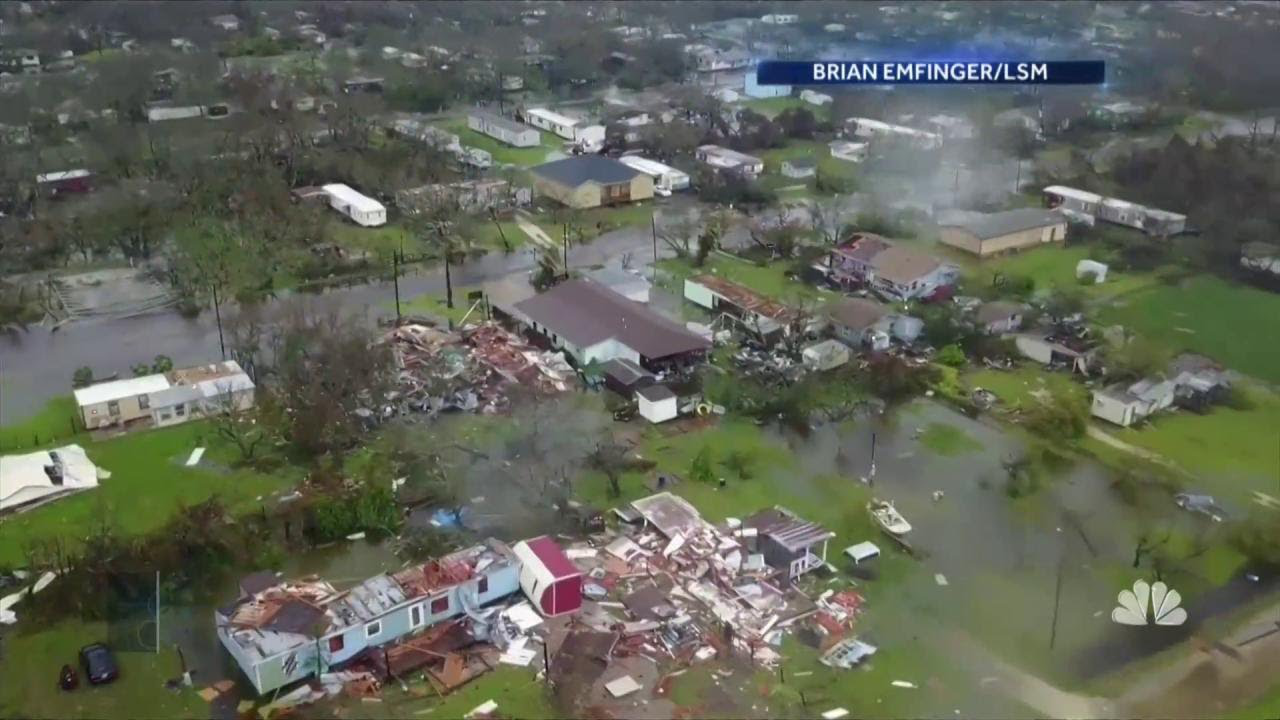

FileNotFoundError: [Errno 2] No such file or directory: '.DS_Store'

In [40]:
from PIL import Image
display(Image.open(open('Photos/8.jpg','rb')))
for file in os.listdir('Photos'):
    display(Image.open(open(file,'rb')))

In [4]:
import math
def distance(lat, lng, lat0, lng0):
    deglen = 110.25
    x = lat - lat0
    y = (lng - lng0)*math.cos(lat0)
    return deglen*math.sqrt(x*x + y*y)

In [13]:
from watson_developer_cloud import VisualRecognitionV3
import json
import os
import getLatLong as geotag

#all photos must be stored in 'Photos' directory (same dir as code)

#tagged_images = [] #[(lat,long),roof_true probability, roof_false probability]


visual_recognition = VisualRecognitionV3(
    '2018-03-19',
    iam_apikey='vFTSKJUVMqQs9h4mHY0wwqI9yPjYS6z1tbv_ZkCfV3SX')

def tag_photos():
    
    lats = []
    longs = []
    rt = []
    rf = []
    
    for file in os.listdir('Photos'):

        direc = 'Photos/' + file

        with open(direc, 'rb') as images_file:
            classes = visual_recognition.classify(
                images_file,
                threshold='0.0',
                owners=["me"]).get_result()
                #classifier_ids=['default']).get_result()

            try:
                roof_false = classes['images'][0]['classifiers'][0]['classes'][0]['score']
            except:
                roof_false = 0
            try:
                roof_true = classes['images'][0]['classifiers'][0]['classes'][1]['score']
            except:
                roof_true = 0


        (lat,long) = geotag.getLatLong(direc)

        lats.append(lat)
        longs.append(long)
        rt.append(roof_true)
        rf.append(roof_false)
        #tagged_images.append([(lat,long),roof_true,roof_false])
        
    return(lats,longs,rt,rf)


In [11]:


#### extra functions
def distance(lat, lng, lat0, lng0):
    deglen = 110.25
    x = lat - lat0
    y = (lng - lng0)*math.cos(lat0)
    return deglen*math.sqrt(x*x + y*y)
    

In [10]:

aprs = []
locData = {}
#input list of volunteer's callsigns, returns

def volunteerLoc(callList):

    aprsWeb = 'https://api.aprs.fi/api/get?name='
    aprsWeb+=callList[0]
    
    for i in range(1,len(callList)):

        aprsWeb+=','
        call = callList[i]
        aprsWeb+= call 


    aprsWeb+='&what=loc&apikey=116932.M4GQQFbrZzOx9&format=json'
    grabaprs = requests.get(aprsWeb)
    jlist = grabaprs.content
    aprs = json.loads(jlist)

    for i in range(0,len(callList)):
        
        locData[aprs['entries'][i]['name']] = [aprs['entries'][i]['lat'],aprs['entries'][i]['lng']]
        
    vollat = [float(location[0]) for location in locData.values()]
    vollong = [float(location[1]) for location in locData.values()]

    return vollat,vollong
    


